In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(tibble)
    library(org.Mm.eg.db)
    library(EnsDb.Mmusculus.v79)
    library(TxDb.Mmusculus.UCSC.mm10.ensGene)
    library(loomR)
    library(reshape2)
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(ggpubr)
    library(DescTools)
    library(ggbeeswarm)
options(stringsAsFactors = FALSE)
})

Warning message:
"package 'DescTools' was built under R version 4.2.3"
Warning message:
"package 'ggbeeswarm' was built under R version 4.2.3"


In [2]:
select <- dplyr::select
filter <- dplyr::filter
rename <- dplyr::rename

In [3]:
make_pdf <- function(object, filename, w, h){
    out_name <- paste0(format(Sys.Date(), "%y%m%d"),"_",filename,".pdf")
    pdf(out_name, width=w, height=h)
        plot(object)
    dev.off()
}

get_plot_limits <- function(plot) {
    gb = ggplot_build(plot)
    xmin = gb$layout$panel_params[[1]]$x.range[1]
    xmax = gb$layout$panel_params[[1]]$x.range[2]
    ymin = gb$layout$panel_params[[1]]$y.range[1]
    ymax = gb$layout$panel_params[[1]]$y.range[2]
    list(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax)
}

In [4]:
setwd("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/")

In [5]:
gene_metadata <- left_join(
                 AnnotationDbi::select(EnsDb.Mmusculus.v79,
                   keys=keys(EnsDb.Mmusculus.v79, keytype="GENEID"),
                   columns=c("SYMBOL","GENESEQSTART", "GENESEQEND"),
                   keytype="GENEID"),
                AnnotationDbi::select(TxDb.Mmusculus.UCSC.mm10.ensGene,
                   keys=keys(TxDb.Mmusculus.UCSC.mm10.ensGene, keytype="GENEID"), 
                   column="CDSCHROM",
                   keytype="GENEID"),
                by="GENEID"
            )

all_wells <- read.table("../metadata/well_barcodes_cell_types")
colnames(all_wells) <- c("Well", "SampleID", "Cell_line")
all_wells <- all_wells %>% mutate(Well_cell_line = paste0(Well, "_", Cell_line))

'select()' returned 1:1 mapping between keys and columns



In [6]:
myPalette <- list("#77270d", "#ee8866", "#d6c941", "#eedd88", "#aaaa00", "#68bd45", "#44bb99", "#41d6c9", "#414ed6", "#77aadd", "#AC8CC1","#ffaabb")
names(myPalette) <- c("bold_red", "red", "bold_yellow", "yellow", "bold_green", "green", "bold_cyan", "cyan", "bold_blue", "blue", "bold_magenta", "magenta")

# XX            # 68bd45 # green
# XCastOMus     # 77A9DB # blue
# XMusOCast     # EE8766 # red
# XMusY         # EEDD88 # yellow
# Deletion 1    # F6A8BA # magenta
# Deletion 2    # 44BC99 # bold_cyan
# Deletion 3    # AC8CC1 # bold_magenta

In [7]:
deletion_metadata <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/Extended_Data_Table_2.csv", 
                                header = TRUE, 
                                sep=",", 
                                colClasses = c("factor", "integer", "integer", NA))

In [8]:
escapees <- c("1810030O07Rik","2010000l03Rik","2010308F09Rik","2610029G23Rik","5530601H04Rik","6720401G13Rik","Abcd1","Araf","Atp6ap2","BC022960","Bgn","Car5b","D330035K16Rik","D930009K15Rik","Ddx3x","Eif1ax","Eif2s3x","Fam50a","Flna","Ftsj1","Fundc1","Gdi1","Gemin8","Gpkow","Huwe1","Idh3g","Igbp1","Ikbkg","Kdm5c","Kdm6a","Lamp2","Maged1","Mbtps2","Med14","Mid1","Mmgt1","Mpp1","Msl3","Ndufb11","Nkap","Ogt","Pbdc1","Pdha1","Prdx4","Rbm3","Renbp","Sh3bgrl","Shroom4","Sms","Suv39h1","Syap1","Tbc1d25","Timp1","Trap1a","Uba1","Usp9x","Utp14a","Uxt","Xist","Yipf6")

In [10]:
gene_metadata <- gene_metadata %>%
    mutate(escapee=case_when(SYMBOL %in% escapees ~ TRUE,
                              TRUE ~ FALSE))

In [ ]:
# NON ALLELIC

In [ ]:
seurat_filt <- readRDS("240424_nonallelic_seurat_obj.rds")

In [ ]:
total_melt <- seurat_filt@assays$UMI@counts %>%
    as.data.frame() %>% 
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line),
           RPK=value/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line), scaling_factor=(sum(na.omit(RPK))/1e6))) %>%
    mutate(TPM=RPK/scaling_factor)

In [ ]:
X_A_data <- total_melt %>% 
    filter(!SYMBOL %in% escapees) %>% 
    mutate(X_or_A=case_when(CDSCHROM=="chrX" ~ "X",
                            CDSCHROM %in% unlist(lapply(1:19, function(x){paste0("chr",x)})) ~ "A")) %>%
    filter(X_or_A %in% c("X", "A")) %>%
    group_by(Well_cell_line, Cell_line, X_or_A) %>%
    summarize(meanTPM=mean(TPM, na.rm = TRUE)) %>%
    select(-Cell_line) %>%
    dcast(Well_cell_line~X_or_A) %>% 
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line))

`summarise()` has grouped output by 'Well_cell_line', 'Cell_line'. You can override using the `.groups` argument.
Adding missing grouping variables: `Cell_line`
Warning message in dcast(., Well_cell_line ~ X_or_A):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."
Using 'meanTPM' as value column. Use 'value.var' to override



In [10]:
quantiles <- total_melt %>% 
    filter(!SYMBOL %in% escapees) %>% 
    group_by(Well_cell_line) %>%
    summarize(quant10=quantile(TPM, probs=(0.1), na.rm=TRUE),
              quant90=quantile(TPM, probs=(0.9), na.rm=TRUE))

In [ ]:
X_A_data_filt <- total_melt %>% 
    left_join(quantiles) %>%
    filter(TPM > quant10,
           TPM < quant90) %>%
    mutate(X_or_A=case_when(CDSCHROM=="chrX" ~ "X",
                            CDSCHROM %in% unlist(lapply(1:19, function(x){paste0("chr",x)})) ~ "A")) %>%
    filter(X_or_A %in% c("X", "A")) %>%
    group_by(Well_cell_line, Cell_line, X_or_A) %>%
    summarize(meanTPM=mean(TPM, na.rm = TRUE)) %>%
    select(-Cell_line) %>%
    dcast(Well_cell_line~X_or_A) %>% 
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line))

Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'Cell_line'. You can override using the `.groups` argument.
Adding missing grouping variables: `Cell_line`
Warning message in dcast(., Well_cell_line ~ X_or_A):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."
Using 'meanTPM' as value column. Use 'value.var' to override



In [ ]:
#          _   _          _   _        
#         | | | |        | | (_)       
#   __ _  | | | |   ___  | |  _    ___ 
#  / _` | | | | |  / _ \ | | | |  / __|
# | (_| | | | | | |  __/ | | | | | (__ 
#  \__,_| |_| |_|  \___| |_| |_|  \___
#
#

In [11]:
seurat_cast <- readRDS("240424_Cast_seurat_obj.rds")
seurat_mus <- readRDS("240424_Mus_seurat_obj.rds")

In [12]:
cast_melt <- seurat_cast@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Cast=value)

mus_melt <- seurat_mus@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Mus=value)

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.

In [13]:
counts_melt <- left_join(cast_melt, mus_melt) %>% 
    mutate(total_counts=Cast+Mus) %>%
    mutate(RPK_total=total_counts/GENELENGTH,
           RPK_cast=Cast/GENELENGTH,
           RPK_mus=Mus/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line),
                        scaling_factor_total=(sum(na.omit(RPK_total))/1e6),
                        scaling_factor_cast=(sum(na.omit(RPK_cast))/1e6),
                        scaling_factor_mus=(sum(na.omit(RPK_mus))/1e6))) %>%
    mutate(TPM_total=RPK_total/scaling_factor_total,
           TPM_cast=RPK_cast/scaling_factor_total,
           TPM_mus=RPK_mus/scaling_factor_total)

counts_melt %>% head

Joining, by = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "escapee", "Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,escapee,Well_cell_line,Cast,Cell_type,⋯,total_counts,RPK_total,RPK_cast,RPK_mus,scaling_factor_total,scaling_factor_cast,scaling_factor_mus,TPM_total,TPM_cast,TPM_mus
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<lgl>,<fct>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,FALSE,J9_XY,1,XY,⋯,2,5.145886e-05,2.572943e-05,2.572943e-05,1.136715e-05,5.834961e-06,5.532191e-06,4.5269789,2.263489,2.2634895
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,FALSE,J9_XY,0,XY,⋯,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,FALSE,J9_XY,0,XY,⋯,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,FALSE,J9_XY,0,XY,⋯,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
5,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,FALSE,J9_XY,1,XY,⋯,2,2.246181e-04,1.123091e-04,1.123091e-04,1.136715e-05,5.834961e-06,5.532191e-06,19.7602834,9.880142,9.8801417
6,ENSMUSG00000000085,Scmh1,120405281,120530186,chr4,124905,FALSE,J9_XY,0,XY,⋯,1,8.006085e-06,0.000000e+00,8.006085e-06,1.136715e-05,5.834961e-06,5.532191e-06,0.7043175,0.000000,0.7043175


In [14]:
quantiles <- counts_melt %>% 
    filter(escapee==FALSE) %>%
    group_by(Well_cell_line) %>%
    summarize(quant10=quantile(TPM_total, probs=(0.1), na.rm=TRUE),
              quant90=quantile(TPM_total, probs=(0.9), na.rm=TRUE))

In [16]:
rm(seurat_cast)
rm(seurat_mus)
rm(cast_melt)
rm(mus_melt)

In [17]:
X_A_data <- counts_melt %>% 
    filter(!SYMBOL %in% escapees) %>% 
    mutate(X_or_A=case_when(CDSCHROM=="chrX" ~ "X",
                            CDSCHROM %in% unlist(lapply(1:19, function(x){paste0("chr",x)})) ~ "A")) %>%
    filter(X_or_A %in% c("X", "A")) %>%
    group_by(Well_cell_line, Cell_type, X_or_A) %>%
    summarize(meanTPM_total=mean(TPM_total, na.rm = TRUE),
              meanTPM_cast=mean(TPM_cast, na.rm = TRUE),
              meanTPM_mus=mean(TPM_mus, na.rm = TRUE)) %>%
    select(-Cell_type) %>%
    dcast(Well_cell_line~X_or_A) %>% 
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line))

`summarise()` has grouped output by 'Well_cell_line', 'Cell_type'. You can override using the `.groups` argument.
Adding missing grouping variables: `Cell_type`
Warning message in dcast(., Well_cell_line ~ X_or_A):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."
Using 'meanTPM_mus' as value column. Use 'value.var' to override



In [18]:
X_A_data_filt <- counts_melt %>% 
    left_join(quantiles) %>%
    filter(TPM_total > quant10,
           TPM_total < quant90) %>%
    mutate(X_or_A=case_when(CDSCHROM=="chrX" ~ "X",
                            CDSCHROM %in% unlist(lapply(1:19, function(x){paste0("chr",x)})) ~ "A")) %>%
    filter(X_or_A %in% c("X", "A")) %>%
    group_by(Well_cell_line, Cell_type, X_or_A) %>%
    summarize(meanTPM_total=mean(TPM_total, na.rm = TRUE),
              meanTPM_cast=mean(TPM_cast, na.rm = TRUE),
              meanTPM_mus=mean(TPM_mus, na.rm = TRUE))

Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'Cell_type'. You can override using the `.groups` argument.


In [24]:
#                                                               _             _     _                 
#                                                              | |           | |   (_)                
#   _ __    ___   _ __    ___    __ _   _ __    _ __     ___   | |_    __ _  | |_   _    ___    _ __  
#  | '__|  / _ \ | '__|  / _ \  / _` | | '_ \  | '_ \   / _ \  | __|  / _` | | __| | |  / _ \  | '_ \ 
#  | |    |  __/ | |    |  __/ | (_| | | | | | | | | | | (_) | | |_  | (_| | | |_  | | | (_) | | | | |
#  |_|     \___| |_|     \___|  \__,_| |_| |_| |_| |_|  \___/   \__|  \__,_|  \__| |_|  \___/  |_| |_|
#                                                                                                     
#                                                                                                     

In [ ]:
corrected_celltype <- X_A_data_filt %>%
    filter(X_or_A=="X") %>%
    mutate(X_ratio=meanTPM_mus/meanTPM_cast) %>%
    mutate(new_cell_type=case_when(X_ratio <= 0.5 & meanTPM_mus < 2 ~ "XCastOMus",
                               X_ratio >= 1.5 & Cell_type != "XY" & meanTPM_cast < 2 ~ "XMusOCast",
                               Cell_type %in% c("XO", "XX") & X_ratio > 0.5 & X_ratio < 1.5 & meanTPM_mus > 2 & meanTPM_cast > 2 ~ "XX",
                               TRUE ~ Cell_type)) %>%
    mutate(reanno_bool = case_when(new_cell_type==Cell_type ~ FALSE,
                                   TRUE ~ TRUE))

corrected_celltype %>% head

In [ ]:
x_status_data <- counts_melt %>% 
    left_join(quantiles) %>%
    left_join(corrected_celltype[,c("Well_cell_line", "reanno_bool")]) %>%
    filter(TPM_total > quant10,
           TPM_total < quant90,
           CDSCHROM=="chrX") %>%
    mutate(mus_ratio=TPM_mus/(TPM_cast+TPM_mus),
           cast_ratio=TPM_cast/(TPM_cast+TPM_mus))

In [18]:
i <- 0
for(gene in unique(arrange(x_status_data, GENESEQSTART)$GENEID)){
    x_status_data[which(x_status_data$GENEID == gene),"gene_pos"] <- i
    i <- i+1
}

i <- 0
for(cell_line in unique(sort(x_status_data$Cell_type))){
    x_status_data[which(x_status_data$Cell_type == cell_line),"cell_line_pos"] <- i
    i <- i+1
    j <- 0
    k <- 0
    for(cell in unique(x_status_data[which(x_status_data$Cell_type == cell_line),"Well_cell_line"])){
        x_status_data[which(x_status_data$Well_cell_line == cell),"cell_pos"] <- j
        j <- j+1
    }
    for(cell in unique(x_status_data[which(x_status_data$Cell_type == cell_line &
                                           x_status_data$reanno_bool == TRUE),"Well_cell_line"])){
        x_status_data[which(x_status_data$Well_cell_line == cell &
                            x_status_data$reanno_bool == TRUE),"new_cell_pos"] <- k
        k <- k+1
    }
}

In [28]:
x_status_plots <- list()
x_status_plots_reassigned <- list()
for(cell_type in c("XX", "XO", "LF1", "LF2", "LF3")){
    x_status_plots[[cell_type]] <- ggplot(x_status_data[which(x_status_data$Cell_type==cell_type),],
                                          aes(xmin=gene_pos-0.5, xmax=gene_pos+0.5, ymin=cell_pos-0.5, ymax=cell_pos+0.5, fill=mus_ratio)) +
    geom_rect() +
    scale_fill_continuous(name="Mus ratio") +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    xlab("Genes on X-chromosome") +
    ylab(paste(cell_type, "cells")) +
    theme(panel.grid=element_blank(),
          panel.background=element_blank(),
          axis.ticks=element_blank(),
          axis.text=element_blank(),
          legend.margin=margin(0,0,0,0, "in"))
    
    x_status_plots_reassigned[[cell_type]] <- ggplot(x_status_data[which(x_status_data$Cell_type==cell_type &
                                                              x_status_data$reanno_bool==TRUE),],
                                          aes(xmin=gene_pos-0.5, xmax=gene_pos+0.5, ymin=new_cell_pos-0.5, ymax=new_cell_pos+0.5, fill=mus_ratio)) +
    geom_rect() +
    scale_fill_continuous(name="Mus ratio") +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    xlab("Genes on X-chromosome") +
    ylab(paste(cell_type, "cells")) +
    theme(panel.grid=element_blank(),
          panel.background=element_blank(),
          axis.ticks=element_blank(),
          axis.text=element_blank(),
          legend.margin=margin(0,0,0,0, "in"))
}

In [ ]:
options(repr.plot.width=8, repr.plot.height=3)
# Reassigned cells
x_status_plots[[1]] / x_status_plots_reassigned[[1]] + guides(fill="none")
x_status_plots[[2]] / x_status_plots_reassigned[[2]] + guides(fill="none")
x_status_plots[[3]] / x_status_plots_reassigned[[3]] + guides(fill="none")
x_status_plots[[4]] / x_status_plots_reassigned[[4]] + guides(fill="none")
x_status_plots[[5]] / x_status_plots_reassigned[[5]] + guides(fill="none")


In [16]:
corrected_celltype <- corrected_celltype %>%
    mutate(new_cell_type=case_when(new_cell_type=="XY" ~ "XMusY",
                                   new_cell_type=="XCastOMus" ~ "XCastOMus",
                                   new_cell_type=="XMusOCast" ~ "XMusOCast",
                                   new_cell_type=="XX" ~ "XX",
                                   new_cell_type=="LF1" ~ "Deletion 1",
                                   new_cell_type=="LF2" ~ "Deletion 2",
                                   new_cell_type=="LF3" ~ "Deletion 3"))

In [17]:
write.table(corrected_celltype, paste0(format(Sys.Date(), "%y%m%d"),"_corrected_celltype.csv"), sep = ",")

In [ ]:
corrected_celltype_data <- X_A_data_filt %>% 
    mutate(meanTPM_ratio=meanTPM_cast/meanTPM_mus) %>% 
    separate(Well_cell_line, into = c("Well", "Cell_line")) %>%
    filter(X_or_A=="X")

corrected_celltype_plot <- ggplot(corrected_celltype_data, aes(x=meanTPM_cast, y=meanTPM_mus, fill=Cell_line)) +
    #scale_fill_manual(values=c(myPalette$green, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$magenta, myPalette$bold_cyan, myPalette$bold_magenta)) +
    geom_abline(slope = 0.5, intercept = 0, color=myPalette$blue, linetype="dashed") +
    geom_abline(slope = 2, intercept = 0, color=myPalette$red, linetype="dashed") +
    geom_vline(xintercept=2, linetype="dashed") +
    geom_hline(yintercept=2, linetype="dashed") +
    xlim(0, 20) +
    ylim(0, 20) +
    geom_point(shape=21, color="black") +
    theme(panel.background=element_blank(),
          panel.grid=element_blank(),
          axis.ticks=element_line(color="black"),
          axis.line=element_line(color="black"),
          axis.text=element_text(size=7, color="black"),
          axis.title=element_text(size=7, color="black"))

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
corrected_celltype_plot
make_pdf(corrected_celltype_plot + theme(legend.position="none"), "corrected_celltype_plot", w=3, h=3)

In [ ]:
#          _           _         
#         | |         | |        
#  _ __   | |   ___   | |_   ___ 
# | '_ \  | |  / _ \  | __| / __|
# | |_) | | | | (_) | | |_  \__ \
# | .__/  |_|  \___/   \__| |___/
# | |                            
# |_|                            

In [19]:
corrected_celltype <- read.table("240613_corrected_celltype.csv", sep=",")

In [20]:
del1_genes <- gene_metadata %>% 
    filter(GENESEQSTART > deletion_metadata[which(deletion_metadata$Deletion=="1"),]$chrX.Start,
           GENESEQEND < deletion_metadata[which(deletion_metadata$Deletion=="1"),]$chrX.End,
           CDSCHROM=="chrX") %>%
    .$GENEID %>%
    unique
del2_genes <- gene_metadata %>% 
    filter(GENESEQSTART > deletion_metadata[which(deletion_metadata$Deletion=="2"),]$chrX.Start,
           GENESEQEND < deletion_metadata[which(deletion_metadata$Deletion=="2"),]$chrX.End,
           CDSCHROM=="chrX") %>%
    .$GENEID %>%
    unique
del3_genes <- gene_metadata %>% 
    filter(GENESEQSTART > deletion_metadata[which(deletion_metadata$Deletion=="3"),]$chrX.Start,
           GENESEQEND < deletion_metadata[which(deletion_metadata$Deletion=="3"),]$chrX.End,
           CDSCHROM=="chrX") %>%
    .$GENEID %>%
    unique

In [ ]:
chrX_gene_sets <- list("All X-linked genes" = filter(gene_metadata, 
                                                    CDSCHROM=="chrX")$GENEID,
                       "X-linked genes inside deletion 1" = del1_genes,
                       "X-linked genes outside deletion 1" = filter(gene_metadata, 
                                                          CDSCHROM=="chrX",
                                                          !GENEID %in% del1_genes)$GENEID,
                       "X-linked genes inside deletion 2" = del2_genes,
                       "X-linked genes outside deletion 2" = filter(gene_metadata, 
                                                          CDSCHROM=="chrX",
                                                          !GENEID %in% del2_genes)$GENEID,
                       "X-linked genes inside deletion 3" = del3_genes,
                       "X-linked genes outside deletion 3" = filter(gene_metadata, 
                                                          CDSCHROM=="chrX",
                                                          !GENEID %in% del3_genes)$GENEID,
                      "PAR genes" = filter(gene_metadata, GENESEQSTART>=169685199, CDSCHROM=="chrX")$GENEID)

In [40]:
# Make X-to-autosome and X-expression plots
X_A_data_genesets <- list()
X_A_data_genesets_plots <- list()
stat_labels_X <- list()
X_A_data <- counts_melt %>% 
        filter(escapee==FALSE) %>%
        left_join(quantiles) %>%
        left_join(corrected_celltype[,c("Well_cell_line", "new_cell_type")])

plot_theme <- theme(axis.line = element_line(),
                        axis.text.y = element_text(size=7, color="black"), 
                        axis.text.x = element_text(size=7, angle=45, hjust=1, vjust=1, color="black"),
                        axis.title.x = element_blank(),
                        axis.title.y = element_text(size=7, color="black"),
                        axis.text.y.right = element_blank(),
                        axis.ticks.y.right = element_blank(),
                        plot.title = element_text(size=8, hjust=0.5),
                        panel.background = element_blank(),
                        panel.grid = element_blank(),
                        legend.position = "none",
                        plot.margin = margin(t=0, r=0, b=0, l=0, "in")
                   )

Joining, by = "Well_cell_line"
Joining, by = "Well_cell_line"


In [23]:
# This is the weird outlier in XMusY for Inside Deletion 2 Cast
# quant10 cutoff is 0, there is one single gene with expression > 0
# so the meanTPM_cast is the TPM_cast of that gene
# which is 26.35422 (Cast = 1 --> TPM_cast 26.35422)

X_A_data %>%
        filter(new_cell_type %in% c("XMusY", "XCastOMus", "XMusOCast", "XX", "Deletion 1", "Deletion 2", "Deletion 3"), #to remove the one stray XO that didn't get reannotated
               TPM_total > quant10,
               TPM_total < quant90,
               GENEID %in% chrX_gene_sets[[4]]) %>%
        mutate(new_cell_type_factor=factor(.$new_cell_type, levels=c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3"))) %>% 
        left_join(summarize(group_by(filter(X_A_data, CDSCHROM %in% lapply(1:19, function(x){paste0("chr",x)})),
                                     Well_cell_line),
                            meanTPM_A_total=mean(TPM_total, na.rm = TRUE),
                            meanTPM_A_cast=mean(TPM_cast, na.rm = TRUE),
                            meanTPM_A_mus=mean(TPM_mus, na.rm = TRUE))) %>%
    group_by(Well_cell_line) %>%
        summarize(meanTPM_total=mean(TPM_total, na.rm = TRUE),
                  meanTPM_cast=mean(TPM_cast, na.rm = TRUE),
                  meanTPM_mus=mean(TPM_mus, na.rm = TRUE),
                  meanTPM_A_total=unique(meanTPM_A_total),
                  meanTPM_A_cast=unique(meanTPM_A_cast),
                  meanTPM_A_mus=unique(meanTPM_A_mus),
                  quant90=unique(quant90)) %>%
    mutate(ratio_cast=meanTPM_cast/meanTPM_A_cast,
               ratio_mus=meanTPM_mus/meanTPM_A_mus) %>%
    filter(Well_cell_line=="K11_XY")

Joining, by = "Well_cell_line"


Well_cell_line,meanTPM_total,meanTPM_cast,meanTPM_mus,meanTPM_A_total,meanTPM_A_cast,meanTPM_A_mus,quant90,ratio_cast,ratio_mus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
K11_XY,26.35422,26.35422,0,69.55146,35.02999,34.52146,61.23019,0.7523331,0


In [23]:
replace_outliers <- function(x) {
    Q1 <- quantile(x, 0.25)
    Q3 <- quantile(x, 0.75)
    IQR <- Q3 - Q1
    x[(x < Q1 - 1.5 * IQR) | (x > Q3 + 1.5 * IQR)] <- NA
    return(as.double(x))
}

In [41]:
for(i in 1:length(chrX_gene_sets)){
    X_A_data_genesets[[i]] <- X_A_data %>%
        filter(new_cell_type %in% c("XMusY", "XCastOMus", "XMusOCast", "XX", "Deletion 1", "Deletion 2", "Deletion 3"), #to remove the one stray XO that didn't get reannotated
               TPM_total > quant10,
               TPM_total < quant90,
               GENEID %in% chrX_gene_sets[[i]]) %>%
        mutate(new_cell_type_factor=factor(.$new_cell_type, levels=c("XX", "XCastOMus", "XMusOCast", "XMusY", "Deletion 1", "Deletion 2", "Deletion 3"))) %>%
        left_join(summarize(group_by(filter(X_A_data, CDSCHROM %in% lapply(1:19, function(x){paste0("chr",x)}),
                                     TPM_total > quant10,
                                     TPM_total < quant90),
                                     Well_cell_line),
                            meanTPM_A_total=mean(TPM_total, na.rm = TRUE),
                            meanTPM_A_cast=mean(TPM_cast, na.rm = TRUE),
                            meanTPM_A_mus=mean(TPM_mus, na.rm = TRUE))) %>%
        group_by(Well_cell_line, new_cell_type_factor) %>%
        summarize(meanTPM_total=mean(TPM_total, na.rm = TRUE),
                  meanTPM_cast=mean(TPM_cast, na.rm = TRUE),
                  meanTPM_mus=mean(TPM_mus, na.rm = TRUE),
                  meanTPM_A_total=meanTPM_A_total,
                  meanTPM_A_cast=meanTPM_A_cast,
                  meanTPM_A_mus=meanTPM_A_mus) %>%
        mutate(ratio_cast=meanTPM_cast/meanTPM_A_cast,
               ratio_mus=meanTPM_mus/meanTPM_A_mus) %>%
        unique() %>% 
        mutate(meanTPM_cast_NA = replace_outliers(meanTPM_cast),
               meanTPM_mus_NA = replace_outliers(meanTPM_mus),
               ratio_cast_NA =  replace_outliers(ratio_cast),
               ratio_mus_NA =  replace_outliers(ratio_mus))
        
    for(ct in unique(X_A_data_genesets[[i]]$new_cell_type_factor)){
        for(col in c("meanTPM_mus", "meanTPM_cast", "ratio_mus", "ratio_cast")){
            X_A_data_genesets[[i]][which(X_A_data_genesets[[i]]$new_cell_type_factor == ct), paste0(col, "_NA")] <- X_A_data_genesets[[i]][which(X_A_data_genesets[[i]]$new_cell_type_factor == ct), col] %>% 
                as.vector() %>% 
                unname() %>% 
                unlist() %>% 
                replace_outliers()
        }
    }
    
    stat_labels_X[[i]] <- list()
    X_A_data_genesets_plots[[i]] <- list()
    for(allele in c("mus", "cast")){ 
        stat_labels_X[[i]][[allele]] <- list()
        X_A_data_genesets_plots[[i]][[allele]] <- list()
        for(comparison in c("XA", "X")){
            stat_labels_X[[i]][[allele]][[comparison]] <- list()
            X_A_data_genesets_plots[[i]][[allele]][[comparison]] <- list()
            yaxis <- case_when(comparison=="XA" ~ paste0("ratio_", allele),
                               comparison=="X" ~ paste0("meanTPM_", allele))
            ylabel <- case_when(allele=="mus" & comparison=="XA" ~ c("X:A ratio", "Mus allele"),
                                allele=="mus" & comparison=="X" ~ c("Mean gene expression (TPM)", "Mus allele"),
                                allele=="cast" & comparison=="XA" ~ c("X:A ratio", "Cast allele"),
                                allele=="cast" & comparison=="X" ~ c("Mean gene expression (TPM)", "Cast allele"))
            
            perc_max <- max(X_A_data_genesets[[i]][, yaxis])*0.05
            
            for(j in 2:length(levels(X_A_data_genesets[[i]]$new_cell_type_factor))){
                ct_max <- max(X_A_data_genesets[[i]][X_A_data_genesets[[i]]$new_cell_type_factor == levels(X_A_data_genesets[[i]]$new_cell_type_factor)[[j]], yaxis])
                k <- j-2
                if(j == 2){
                    if(ct_max > max(X_A_data_genesets[[i]][X_A_data_genesets[[i]]$new_cell_type_factor == "XX", yaxis])){
                        stat_labels_X[[i]][[allele]][[comparison]] <- append(stat_labels_X[[i]][[allele]][[comparison]], ct_max+perc_max)
                    } else {
                        stat_labels_X[[i]][[allele]][[comparison]] <- append(stat_labels_X[[i]][[allele]][[comparison]], max(X_A_data_genesets[[i]][X_A_data_genesets[[i]]$new_cell_type_factor == "XX", yaxis])+perc_max)
                    }
                } else {
                    if(ct_max > stat_labels_X[[i]][[allele]][[comparison]][[k]]){
                        stat_labels_X[[i]][[allele]][[comparison]] <- append(stat_labels_X[[i]][[allele]][[comparison]], ct_max+perc_max)
                    } else {
                        stat_labels_X[[i]][[allele]][[comparison]] <- append(stat_labels_X[[i]][[allele]][[comparison]], stat_labels_X[[i]][[allele]][[comparison]][[k]]+perc_max)
                    }
                }
            }
            
            X_A_data_genesets_plots[[i]][[allele]][[comparison]] <- ggplot(X_A_data_genesets[[i]], aes_string(x="new_cell_type_factor", y=yaxis, fill="new_cell_type_factor")) +
                geom_violin(aes_string(y=paste0(yaxis, "_NA")),
                            color="black",
                            #kernel="cosine",
                            scale="width", 
                            draw_quantiles=c(0.5)) +
                geom_boxplot(aes_string(y=yaxis), linewidth=0, size=0, outlier.size = 0.5, linetype=0, fill=NA, color=NA, outlier.color = "#000000") +
                scale_x_discrete(labels=c("XX", bquote(X^"Cast"*O^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"), "Deletion 1", "Deletion 2", "Deletion 3")) +
                scale_fill_manual(values=c(myPalette$green, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$magenta, myPalette$bold_cyan, myPalette$bold_magenta)) +
                geom_quasirandom(size=0.624, shape=21, color="#000000", stroke=0.355) +
                geom_hline(yintercept=mean(unlist(unname(as.vector(X_A_data_genesets[[i]][which(X_A_data_genesets[[i]]$new_cell_type_factor=="XX"), yaxis]))), na.rm=TRUE),
                           color="#696969",
                           linetype="dashed") +
                coord_cartesian(clip = "off", ylim=(c(-0.05, NA)), expand=FALSE) + 
                stat_compare_means(label="p.signif", 
                                   method="wilcox", 
                                   ref.group="XX",
                                   label.y=unlist(stat_labels_X[[i]][[allele]][[comparison]]),
                                   comparisons=list(c("XX", "XCastOMus"), c("XX", "XMusOCast"), c("XX", "XMusY"), c("XX", "Deletion 1"), c("XX", "Deletion 2"), c("XX", "Deletion 3")),
                                   size=7*0.352777778,
                                   hjust=0.5,
                                   vjust=0.5,
                                   family='sans',
                                   tip.length=0.00,
                                   hide.ns=FALSE) +
                ylab(ylabel[[1]]) +
                ggtitle(paste0(names(chrX_gene_sets)[[i]], "\n", ylabel[[2]])) +
                plot_theme
        }
    }
}

Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'new_cell_type_factor'. You can override using the `.groups` argument.
Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'new_cell_type_factor'. You can override using the `.groups` argument.
Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'new_cell_type_factor'. You can override using the `.groups` argument.
Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'new_cell_type_factor'. You can override using the `.groups` argument.
Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'new_cell_type_factor'. You can override using the `.groups` argument.
Joining, by = "Well_cell_line"
`summarise()` has grouped output by 'Well_cell_line', 'new_cell_type_factor'. You can override using the `.groups` argument.
Joining, by = "Well_cell_line"
`summarise()` has grouped output 

Warning message:
"Removed 7 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 19 rows containing non-finite values (`stat_ydensity()`)."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scal

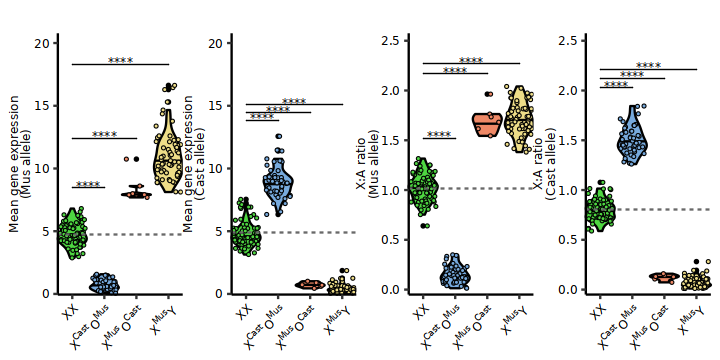

In [23]:
options(repr.plot.width=6, repr.plot.height=3)
max_y <- max(get_plot_limits(X_A_data_genesets_plots[[1]][["mus"]][["X"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[1]][["cast"]][["X"]])$ymax)
fig1_plots <- list()
fig1_plots[[1]] <- X_A_data_genesets_plots[[1]][["mus"]][["X"]] + 
    ggtitle("") + 
    ylim(0, max_y) +
    scale_x_discrete(limits=c("XX", "XCastOMus", "XMusOCast", "XMusY"),
                     labels=c("XX", bquote(X^"Cast"*O^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"))) +
    scale_fill_manual(values=c(myPalette$magenta, myPalette$blue, myPalette$red, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$green)) +
    stat_compare_means(label="p.signif", 
                       method="wilcox", 
                       ref.group="XX",
                       comparisons=list(c("XX", "XCastOMus"), c("XX", "XMusOCast"), c("XX", "XMusY")),
                       label.y=unlist(stat_labels_X[[1]][["mus"]][["X"]]),
                       size=7*0.352777778,
                       hjust=0.5,
                       vjust=0.5,
                       family='sans',
                       tip.length=0.00,
                       hide.ns=FALSE)

fig1_plots[[2]] <- X_A_data_genesets_plots[[1]][["cast"]][["X"]] + 
    ggtitle("") + 
    ylim(0, max_y) +
    scale_x_discrete(limits=c("XX", "XCastOMus", "XMusOCast", "XMusY"),
                     labels=c("XX", bquote(X^"Cast"*O^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"))) +
    scale_fill_manual(values=c(myPalette$magenta, myPalette$blue, myPalette$red, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$green)) +
    stat_compare_means(label="p.signif", 
                       method="wilcox", 
                       ref.group="XX",
                       comparisons=list(c("XX", "XCastOMus"), c("XX", "XMusOCast"), c("XX", "XMusY")),
                       label.y=unlist(stat_labels_X[[1]][["cast"]][["X"]]),
                       size=7*0.352777778,
                       hjust=0.5,
                       vjust=0.5,
                       family='sans',
                       tip.length=0.00,
                       hide.ns=FALSE)

max_y <- max(get_plot_limits(X_A_data_genesets_plots[[1]][["mus"]][["XA"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[1]][["cast"]][["XA"]])$ymax)
fig1_plots[[3]] <- X_A_data_genesets_plots[[1]][["mus"]][["XA"]] + 
    ggtitle("") + 
    ylim(0, max_y) +
    scale_x_discrete(limits=c("XX", "XCastOMus", "XMusOCast", "XMusY"),
                     labels=c("XX", bquote(X^"Cast"*O^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"))) +
    scale_fill_manual(values=c(myPalette$magenta, myPalette$blue, myPalette$red, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$green)) +
    stat_compare_means(label="p.signif", 
                       method="wilcox", 
                       ref.group="XX",
                       comparisons=list(c("XX", "XCastOMus"), c("XX", "XMusOCast"), c("XX", "XMusY")),
                       label.y=unlist(stat_labels_X[[1]][["mus"]][["XA"]]),
                       size=7*0.352777778,
                       hjust=0.5,
                       vjust=0.5,
                       family='sans',
                       tip.length=0.00,
                       hide.ns=FALSE)

fig1_plots[[4]] <- X_A_data_genesets_plots[[1]][["cast"]][["XA"]] + 
    ggtitle("") + 
    ylim(0, max_y) +
    scale_x_discrete(limits=c("XX", "XCastOMus", "XMusOCast", "XMusY"),
                     labels=c("XX", bquote(X^"Cast"*O^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"))) +
    scale_fill_manual(values=c(myPalette$magenta, myPalette$blue, myPalette$red, myPalette$blue, myPalette$red, myPalette$yellow, myPalette$green)) +
    stat_compare_means(label="p.signif", 
                       method="wilcox", 
                       ref.group="XX",
                       comparisons=list(c("XX", "XCastOMus"), c("XX", "XMusOCast"), c("XX", "XMusY")),
                       label.y=unlist(stat_labels_X[[1]][["cast"]][["XA"]]),
                       size=7*0.352777778,
                       hjust=0.5,
                       vjust=0.5,
                       family='sans',
                       tip.length=0.00,
                       hide.ns=FALSE)
wrap_plots(fig1_plots, nrow=1)

In [101]:
make_pdf(wrap_plots(fig1_plots, nrow=1), "fig1_all_x", h=3, w=6.5)

Warning message:
"Removed 149 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 144 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 144 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 144 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 144 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 159 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 144 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 144 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 144 rows containing non-finite values (`stat

png 
  2

In [31]:
extdata3_plots <- list()
#All X-linked genes (Mus/Cast, X, XA)
max_y_x <- max(get_plot_limits(X_A_data_genesets_plots[[1]][["mus"]][["X"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[1]][["cast"]][["X"]])$ymax)
max_y_xa <- max(get_plot_limits(X_A_data_genesets_plots[[1]][["mus"]][["XA"]])$ymax,
             get_plot_limits(X_A_data_genesets_plots[[1]][["cast"]][["XA"]])$ymax)


extdata3_plots[[1]] <- X_A_data_genesets_plots[[1]][["mus"]][["X"]] + ggtitle("") + ylim(0, max_y_x) | 
    X_A_data_genesets_plots[[1]][["cast"]][["X"]] + ggtitle("") + ylim(0, max_y_x) |
    X_A_data_genesets_plots[[1]][["mus"]][["XA"]]  + ggtitle("") + ylim(0, max_y_xa) |
    X_A_data_genesets_plots[[1]][["cast"]][["XA"]]  + ggtitle("") + ylim(0, max_y_xa) 

max_y <- max(get_plot_limits(X_A_data_genesets_plots[[3]][["mus"]][["X"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[5]][["mus"]][["X"]])$ymax,
             get_plot_limits(X_A_data_genesets_plots[[7]][["cast"]][["XA"]])$ymax)
#Outside (Mus/Mus/Cast)
extdata3_plots[[2]] <- X_A_data_genesets_plots[[3]][["mus"]][["X"]] | X_A_data_genesets_plots[[5]][["mus"]][["X"]] | X_A_data_genesets_plots[[7]][["cast"]][["X"]]

Warning message:
"Removed 7 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 19 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 6 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 9 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 3 rows containing non-finite values (`stat_ydensity()`)."


Warning message:
"Removed 7 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 19 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 6 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 9 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_ydensity()`)."


[[1]]

[[2]]


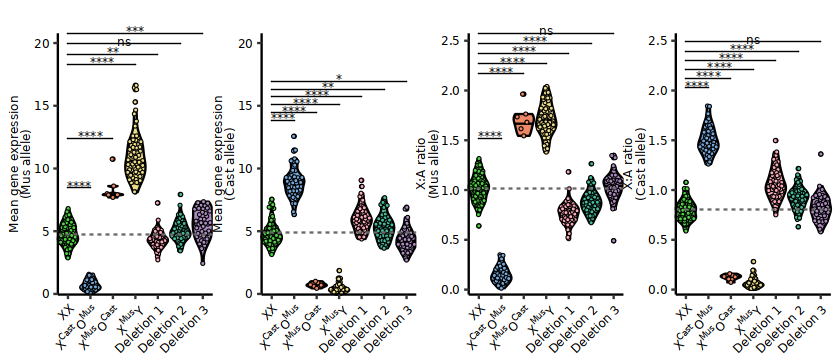

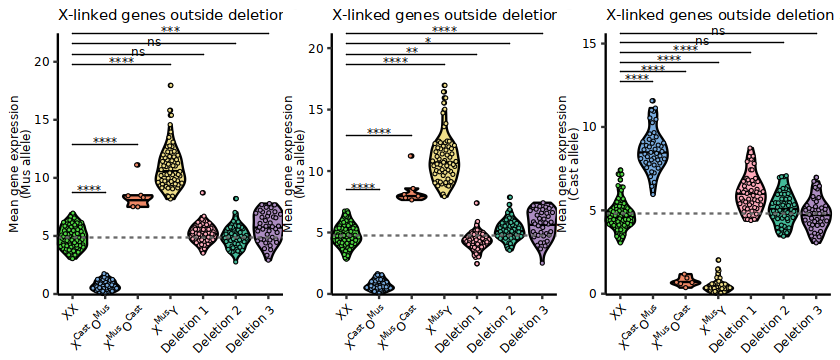

In [32]:
extdata3_plots

In [28]:
make_pdf(extdata3_plots[[1]], "extdata3_plots_all_x", w=5, h=2.5)

Warning message:
"Removed 7 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 19 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."


png 
  2

In [29]:
make_pdf(extdata3_plots[[2]], "extdata3_plot_outside", w=7, h=3)

Warning message:
"Removed 6 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 9 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_ydensity()`)."


png 
  2

In [44]:
fig2_plots <- list()
#Outside (Cast/Cast/Mus)
max_y <- max(get_plot_limits(X_A_data_genesets_plots[[3]][["cast"]][["X"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[5]][["cast"]][["X"]])$ymax,
             get_plot_limits(X_A_data_genesets_plots[[7]][["mus"]][["X"]])$ymax)

fig2_plots[[1]] <- (X_A_data_genesets_plots[[3]][["cast"]][["X"]] + 
                        ylim(0, max_y) +
                        scale_x_discrete(limits=c("XX", "XCastOMus","Deletion 1"),
                                         labels=c(bquote(X^"Cast"*X^"Mus"), bquote(X^"Cast"*O^"Mus"),  "Deletion 1")) +
                        scale_fill_manual(values=c(myPalette$green, myPalette$blue, myPalette$magenta)) +
                        stat_compare_means(label="p.signif", 
                                           method="wilcox", 
                                           ref.group="XX",
                                           comparisons=list(c("XX", "XCastOMus"), c("XX", "Deletion 1")),
                                           label.y=unlist(stat_labels_X[[3]][["cast"]][["X"]][1:3]),
                                           size=7*0.352777778,
                                           hjust=0.5,
                                           vjust=0.5,
                                           family='sans',
                                           tip.length=0.00,
                                           hide.ns=FALSE)) |
    (X_A_data_genesets_plots[[5]][["cast"]][["X"]] + 
         ylim(0, max_y) +
         scale_x_discrete(limits=c("XX", "XCastOMus", "Deletion 2"),
                          labels=c(bquote(X^"Cast"*X^"Mus"), bquote(X^"Cast"*O^"Mus"), "Deletion 2")) +
        scale_fill_manual(values=c(myPalette$green, myPalette$blue, myPalette$bold_cyan)) +
         stat_compare_means(label="p.signif", 
                            method="wilcox", 
                            ref.group="XX",
                            comparisons=list(c("XX", "XCastOMus"), c("XX", "Deletion 2")),
                            label.y=unlist(stat_labels_X[[5]][["cast"]][["X"]][c(1,2,4)]),
                            size=7*0.352777778,
                            hjust=0.5,
                            vjust=0.5,
                            family='sans',
                            tip.length=0.00,
                            hide.ns=FALSE)) |
    (X_A_data_genesets_plots[[7]][["mus"]][["X"]] + 
         ylim(0, max_y) +
         scale_x_discrete(limits=c("XX", "XMusOCast", "XMusY", "Deletion 3"), 
                          labels=c(bquote(X^"Cast"*X^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"), "Deletion 3")) + 
        scale_fill_manual(values=c(myPalette$green, myPalette$red, myPalette$yellow, myPalette$bold_magenta)) +
         stat_compare_means(label="p.signif", 
                            method="wilcox", 
                            ref.group="XX",
                            comparisons=list(c("XX", "XMusOCast"), c("XX", "XMusY"), c("XX", "Deletion 3")),
                            label.y=unlist(stat_labels_X[[7]][["mus"]][["X"]][c(2,3,6)]),
                            size=7*0.352777778,
                            hjust=0.5,
                            vjust=0.5,
                            family='sans',
                            tip.length=0.00,
                            hide.ns=FALSE))

Warning message:
"Removed 13 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 17 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
"Removed 165 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 159 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 168 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 160 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 160 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 160 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 150 rows containing non-finite values (`

[[1]]


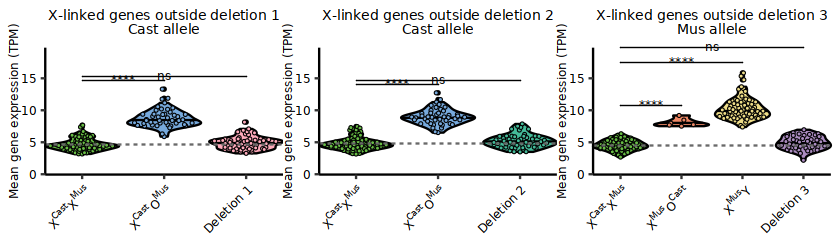

In [47]:
options(repr.plot.width=7, repr.plot.height=2)
fig2_plots

In [48]:
make_pdf(fig2_plots[[1]], "fig2_plots", w=7, h=2)

Warning message:
"Removed 165 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 159 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 168 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 160 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 160 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 160 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 150 rows containing non-finite values (`

png 
  2

Warning message:
"Removed 9 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 17 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 8 rows containing non-finite values (`stat_ydensity()`)."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Removed 163 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 159 rows containing mis

[[1]]


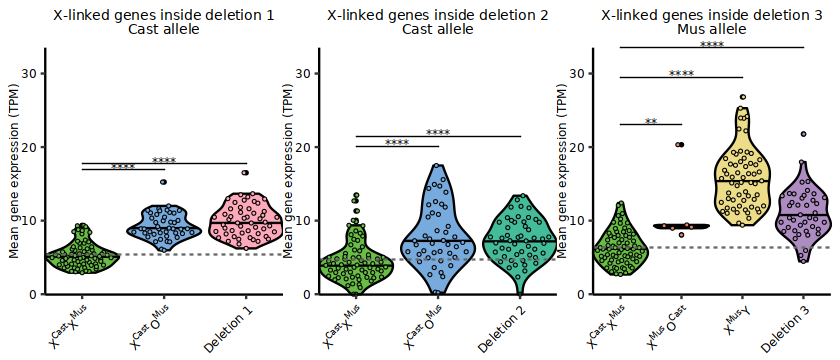

In [51]:
options(repr.plot.width=7, repr.plot.height=3)
fig3_plots <- list()
#Inside (Cast/Cast/Mus)
max_y <- max(get_plot_limits(X_A_data_genesets_plots[[2]][["cast"]][["X"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[4]][["cast"]][["X"]])$ymax,
             get_plot_limits(X_A_data_genesets_plots[[6]][["mus"]][["X"]])$ymax)
fig3_plots[[1]] <- X_A_data_genesets_plots[[2]][["cast"]][["X"]] + ylim(0, max_y)  +
                        scale_x_discrete(limits=c("XX", "XCastOMus","Deletion 1"),
                                         labels=c(bquote(X^"Cast"*X^"Mus"), bquote(X^"Cast"*O^"Mus"),  "Deletion 1")) +
                        scale_fill_manual(values=c(myPalette$green, myPalette$blue, myPalette$magenta)) +
                        stat_compare_means(label="p.signif", 
                                           method="wilcox", 
                                           ref.group="XX",
                                           comparisons=list(c("XX", "XCastOMus"), c("XX", "Deletion 1")),
                                           label.y=unlist(stat_labels_X[[2]][["cast"]][["X"]][1:3]),
                                           size=7*0.352777778,
                                           hjust=0.5,
                                           vjust=0.5,
                                           family='sans',
                                           tip.length=0.00,
                                           hide.ns=FALSE) | 
    X_A_data_genesets_plots[[4]][["cast"]][["X"]] + ylim(0, max_y)  +
         scale_x_discrete(limits=c("XX", "XCastOMus", "Deletion 2"),
                          labels=c(bquote(X^"Cast"*X^"Mus"), bquote(X^"Cast"*O^"Mus"), "Deletion 2")) +
        scale_fill_manual(values=c(myPalette$green, myPalette$blue, myPalette$bold_cyan)) +
         stat_compare_means(label="p.signif", 
                            method="wilcox", 
                            ref.group="XX",
                            comparisons=list(c("XX", "XCastOMus"), c("XX", "Deletion 2")),
                            label.y=unlist(stat_labels_X[[4]][["cast"]][["X"]][c(1,2,4)]),
                            size=7*0.352777778,
                            hjust=0.5,
                            vjust=0.5,
                            family='sans',
                            tip.length=0.00,
                            hide.ns=FALSE) | 
    X_A_data_genesets_plots[[6]][["mus"]][["X"]] + ylim(0, max_y)  +
         scale_x_discrete(limits=c("XX", "XMusOCast", "XMusY", "Deletion 3"), 
                          labels=c(bquote(X^"Cast"*X^"Mus"), bquote(X^"Mus"*O^"Cast"), bquote(X^"Mus"*"Y"), "Deletion 3")) + 
        scale_fill_manual(values=c(myPalette$green, myPalette$red, myPalette$yellow, myPalette$bold_magenta)) +
         stat_compare_means(label="p.signif", 
                            method="wilcox", 
                            ref.group="XX",
                            comparisons=list(c("XX", "XMusOCast"), c("XX", "XMusY"), c("XX", "Deletion 3")),
                            label.y=unlist(stat_labels_X[[6]][["mus"]][["X"]][c(2,3,6)]),
                            size=7*0.352777778,
                            hjust=0.5,
                            vjust=0.5,
                            family='sans',
                            tip.length=0.00,
                            hide.ns=FALSE)
fig3_plots

In [52]:
make_pdf(fig3_plots[[1]], "fig3_plots", w=6, h=2)

Warning message:
"Removed 163 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 159 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 164 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 159 rows containing missing values (`stat_boxplot()`)."
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `wilcox.test.default()`:
! not enough 'y' observations"
Warning message:
"Removed 159 rows containing non-finite values (`stat_signif()`)."
Warning message:
"Removed 151 rows containing non-finite values (`

png 
  2

Warning message:
"Removed 11 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 11 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 22 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 11 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 11 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 22 rows containing non-finite values (`stat_ydensity()`)."


[[1]]


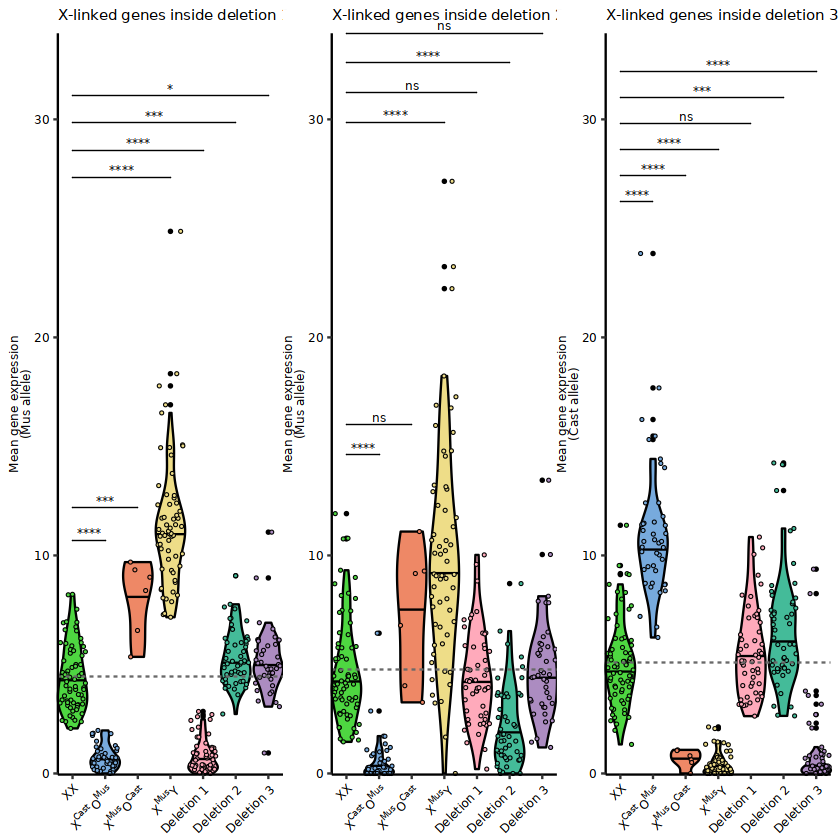

In [30]:
extdata5_plots <- list()
#Inside (Mus/Mus/Cast)
max_y <- max(get_plot_limits(X_A_data_genesets_plots[[2]][["mus"]][["X"]])$ymax, 
             get_plot_limits(X_A_data_genesets_plots[[4]][["mus"]][["X"]])$ymax,
             get_plot_limits(X_A_data_genesets_plots[[6]][["cast"]][["X"]])$ymax)

extdata5_plots[[1]] <- X_A_data_genesets_plots[[2]][["mus"]][["X"]] + ylim(0, max_y) | 
    X_A_data_genesets_plots[[4]][["mus"]][["X"]]  + ylim(0, max_y) |
    X_A_data_genesets_plots[[6]][["cast"]][["X"]]  + ylim(0, max_y)
extdata5_plots

In [31]:
make_pdf(extdata5_plots[[1]], "extdata5_plots", w=7, h=3)

Warning message:
"Removed 11 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 11 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 22 rows containing non-finite values (`stat_ydensity()`)."


png 
  2

In [164]:
sig_test <- function(data, allele_col, col){
    data <- as.data.frame(data)
    dunnett <- DunnettTest(data[,allele_col], data[,col])[[1]] %>% as.data.frame() %>% mutate(test="dunnett") %>% rownames_to_column("comparison")
    anova <- aov(get(allele_col) ~ get(col), data)
    t_hsd <- TukeyHSD(anova)[[1]] %>% as.data.frame() %>% mutate(test="tukey") %>% head(6) %>% rename(pval=`p adj`,lwr.ci=lwr,upr.ci=upr) %>% rownames_to_column("comparison")
    out <- rbind(dunnett, t_hsd) %>% mutate(sig_sym=case_when(`pval`<0.0001 ~ "****", `pval`<0.001 ~ "***", `pval`<0.01 ~ "**", `pval`<0.05 ~ "*", TRUE ~ ""))
    return(out)
}

In [169]:
sig_test_outlist <- list()
for(i in seq(1:7)){
    sig_test_outlist[[i]] <- list()
    for(allele in c("meanTPM_cast", "meanTPM_mus")){
        sig_test_outlist[[i]][[allele]] <- sig_test(X_A_data_genesets[[i]], allele, "new_cell_type_factor")
    }
}
names(sig_test_outlist) <- names(chrX_gene_sets)[1:7]

In [170]:
sig_test_outlist

comparison,diff,lwr.ci,upr.ci,pval,test,sig_sym
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
XCastOMus-XX,4.0831260,3.59988668,4.56636524,0.000000e+00,dunnett,****
XMusOCast-XX,-4.1331494,-5.19926514,-3.06703369,0.000000e+00,dunnett,****
XMusY-XX,-4.4119270,-4.85213311,-3.97172082,0.000000e+00,dunnett,****
Deletion 1-XX,1.1361179,0.67613639,1.59609937,3.025475e-09,dunnett,****
Deletion 2-XX,0.4400007,-0.02254526,0.90254663,6.994758e-02,dunnett,
Deletion 3-XX,-0.4811132,-0.97502991,0.01280359,5.981034e-02,dunnett,
XCastOMus-XX,4.0831260,3.53487036,4.63138156,1.075917e-12,tukey,****
XMusOCast-XX,-4.1331494,-5.34270323,-2.92359560,1.141087e-12,tukey,****
XMusY-XX,-4.4119270,-4.91135963,-3.91249429,1.075917e-12,tukey,****
